# Parity Classification Using VQC

## Import All Package

In [3]:
import time

import numpy as np
import os

import torch
from torch import nn
from torch.nn import Linear
from torch import optim
from torch.autograd import Variable
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import pennylane as qml
import pickle

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Define Hyperparameter

In [4]:
epochs = 500
lr = 1e-2

num_qubits = 5
n_layers = 2
batch_size = (2**num_qubits)//4

## Generate Parity Data

In [6]:
X = np.arange(2 ** num_qubits)
X = X.reshape(-1,1)
X = X.astype(np.uint8)
X = np.unpackbits(X, 1)[:, -num_qubits:]
X = X.astype(np.float64)
y = np.sum(X, axis=1)%2

test_choice = np.r_[np.random.choice(np.argwhere(y == 0).reshape(-1), len(y)//8, False), 
                    np.random.choice(np.argwhere(y == 1).reshape(-1), len(y)//8, False)]
train_choice = np.array([i for i in range(2 ** num_qubits) if i not in test_choice])

X_train = X[train_choice]
X_test = X[test_choice]
y_train = y[train_choice]
y_test = y[test_choice]

y_train = y_train*2-1
y_test = y_test*2-1

X_train = torch.tensor(X_train, requires_grad=False).double()
X_test = torch.tensor(X_test, requires_grad=False).double()
y_train = torch.tensor(y_train, requires_grad=False).double()
y_test = torch.tensor(y_test, requires_grad=False).double()


train_loader = torch.utils.data.DataLoader(
    list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True, drop_last=True, num_workers = 0
)
test_loader = torch.utils.data.DataLoader(
    list(zip(X_test, y_test)), batch_size=batch_size, shuffle=True, drop_last=True, num_workers = 0
)

## Define VQC Model

In [7]:
dev = qml.device("default.qubit.torch", wires=num_qubits)

def layer(W):

    for i in range(num_qubits):
        qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)

    for i in range(num_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

    if num_qubits > 2:
        qml.CNOT(wires=[num_qubits - 1, 0])

@qml.qnode(dev, interface="torch", diff_method="backprop")
def circuit(inputs, weights):

    qml.BasisState(inputs, wires=range(num_qubits))

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

# Construct model

weight_shapes = {"weights": (n_layers, num_qubits, 3)}
qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)

model = nn.Sequential(qlayer)

optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fun = nn.MSELoss()


## Train VQC Model

In [8]:
print("start", f"model_{num_qubits}_{n_layers}")
ST = time.time()
train_loss, train_acc, test_loss, test_acc = [], [], [], []
for epoch in range(epochs):
    loss_sum, total_cnt, correct_cnt = 0, 0, 0
    model.train()
    for X,y in train_loader:
        X, y = Variable(X), Variable(y)
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(X)
        loss= loss_fun(out,y)
        loss.backward()
        optimizer.step()
        pred_y = torch.sign(out)

        total_cnt += y.data.shape[0]
        # y = torch.argmax(y, axis=1)
        correct_cnt += (pred_y == y).sum()
        loss_sum += loss.item()
    train_loss.append(loss_sum / total_cnt)
    train_acc.append(float(correct_cnt) / total_cnt)
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch + 1:3d}/{epochs:3d}\nTrain Loss: {train_loss[-1]:.10f} '
              f'Train Acc: {train_acc[-1]:.5f} Use Time: {time.time()-ST:5f}')
    loss_sum, total_cnt, correct_cnt = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for X,y in test_loader:
            X, y = Variable(X), Variable(y)
            if torch.cuda.is_available():
                X, y = X.cuda(), y.cuda()
            out = model(X)
            loss= loss_fun(out,y)
            pred_y = torch.sign(out)
            total_cnt += y.data.shape[0]
            # y = torch.argmax(y, axis=1)
            correct_cnt += (pred_y == y).sum()
            loss_sum += loss.item()
        test_loss.append(loss_sum / total_cnt)
        test_acc.append(float(correct_cnt) / total_cnt)
    if (epoch + 1) % 100 == 0:
        print(f'Test Loss: {test_loss[-1]:.10f} '
              f'Test Acc: {test_acc[-1]:.5f} Use Time: {time.time()-ST:5f}')
    if (test_loss[-1] < 0.01) and (test_acc[-1] > 0.99):
        print(f'Epoch {epoch + 1:3d}/{epochs:3d}\nTrain Loss: {train_loss[-1]:.10f} '
              f'Train Acc: {train_acc[-1]:.5f} Use Time: {time.time()-ST:5f}')
        print(f'Test Loss: {test_loss[-1]:.10f} '
              f'Test Acc: {test_acc[-1]:.5f} Use Time: {time.time()-ST:5f}')
        break

start model_5_2
Epoch 100/500
Train Loss: 0.0372475391 Train Acc: 1.00000 Use Time: 93.709115
Test Loss: 0.0447095435 Test Acc: 1.00000 Use Time: 93.886229
Epoch 135/500
Train Loss: 0.0079068322 Train Acc: 1.00000 Use Time: 126.170781
Test Loss: 0.0099407177 Test Acc: 1.00000 Use Time: 126.170954


## Plot Learning Curve

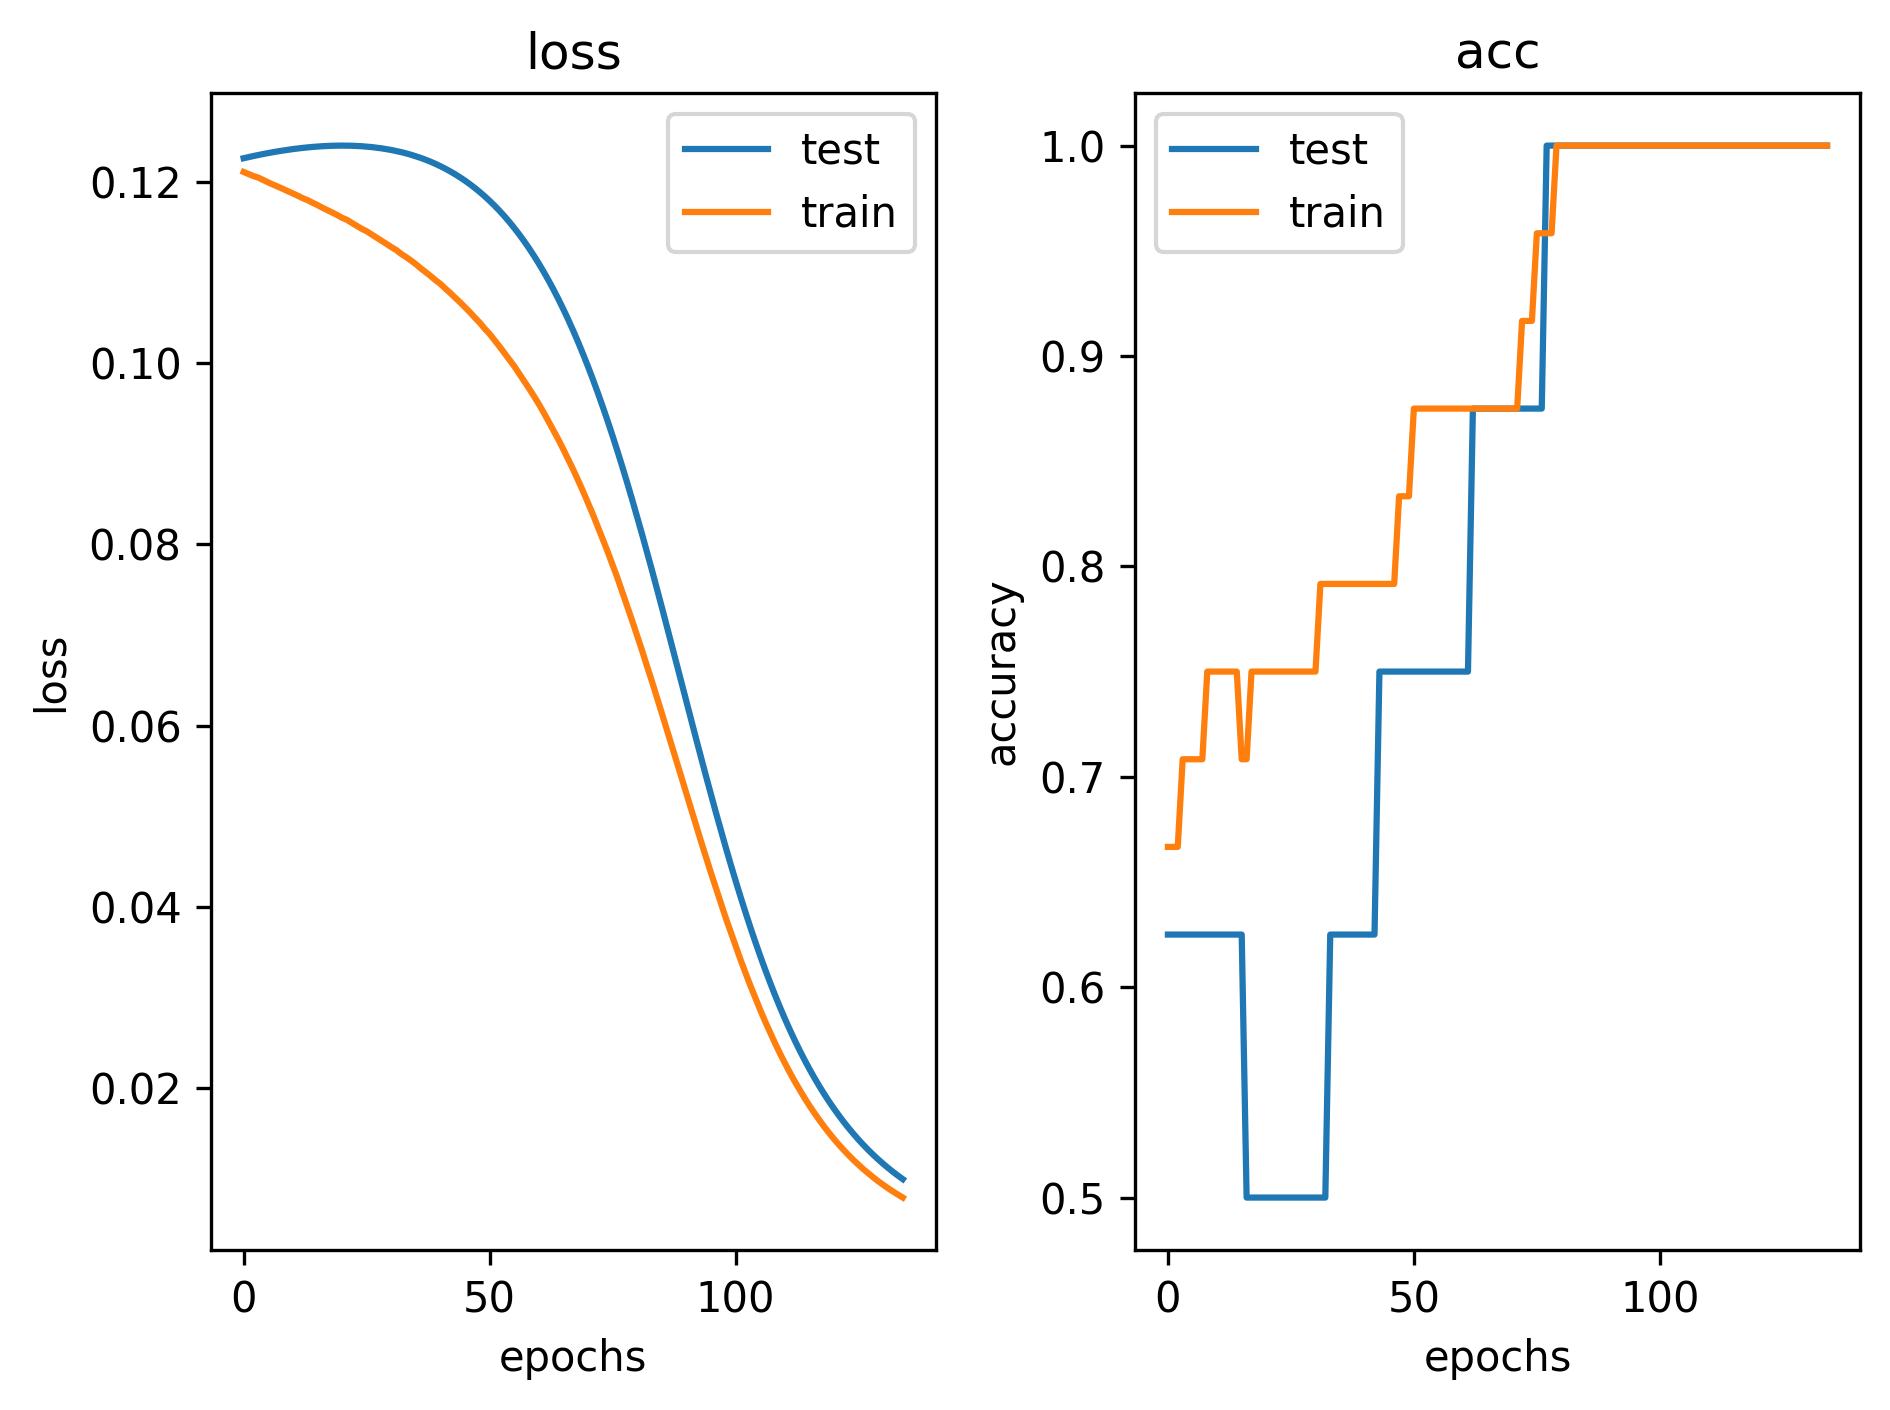

In [9]:
plt.figure(dpi=300)
plt.subplot(1, 2, 1)
plt.plot(range(epoch + 1), test_loss, label='test')
plt.plot(range(epoch + 1), train_loss, label='train')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title('loss')
plt.subplot(1, 2, 2)
plt.plot(range(epoch + 1), test_acc, label='test')
plt.plot(range(epoch + 1), train_acc, label='train')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('acc')
plt.tight_layout()
plt.show()

## Save Learning Curve and parameters

In [10]:
out = model(X_test)
print(out)
pred_y = torch.sign(out)
print(pred_y)
torch.save(model.state_dict(), f"model_{num_qubits}_{n_layers}.pkl")
with open(f'data_{num_qubits}_{n_layers}.pkl', 'wb') as f:
    pickle.dump({'X_train': X_train.detach().numpy(), 
                 'X_test': X_test.detach().numpy(), 
                 'y_train': y_train.detach().numpy(), 
                 'y_test': y_test.detach().numpy(), 
                 'out_train': model(X_train).detach().numpy(), 
                 'out_test': model(X_test).detach().numpy(), 
                 'parameters': next(model.parameters()).detach().numpy()}, f)

tensor([-0.7740, -0.7058, -0.7455, -0.6450,  0.7743,  0.7082,  0.7089,  0.7052],
       dtype=torch.float64, grad_fn=<StackBackward0>)
tensor([-1., -1., -1., -1.,  1.,  1.,  1.,  1.], dtype=torch.float64,
       grad_fn=<SignBackward0>)
